/net/dali/home/mscbio/rul98/miniconda3/envs/struct/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_1242912/3511216580.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['observation_datetime'].dt.to_period('M')


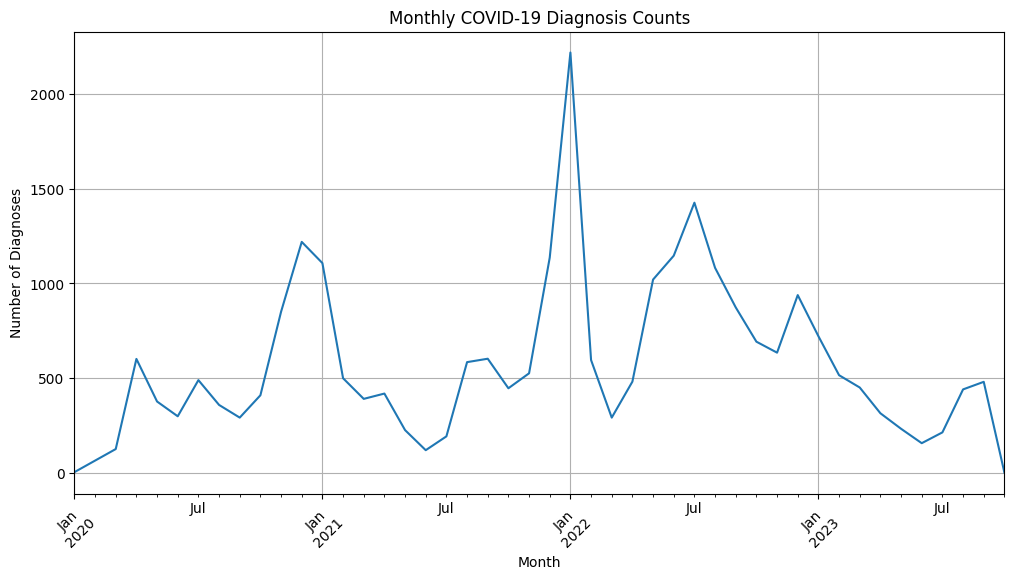

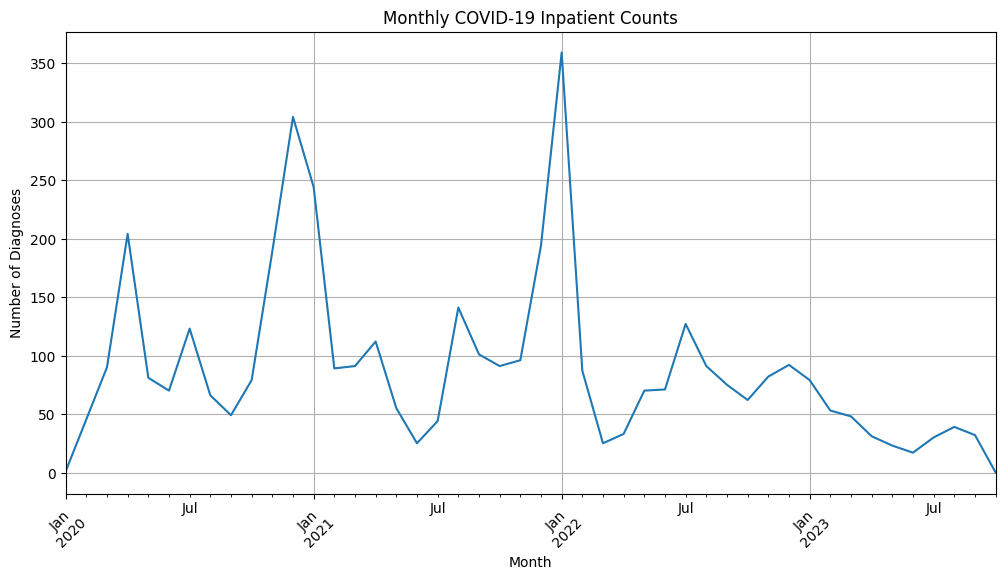

In [ ]:
from SGShift import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('../data/CovidCom.csv', index_col= 0)
df['ethnicity_Hispanic'] = np.where(df['ethnicity'] == 'Hispanic or Latino', 1, 0)
df['ethnicity_NotHispanic'] = np.where(df['ethnicity'] == 'Not Hispanic or Latino ', 1, 0)
df['age_group'] = pd.cut(df['age'], bins=[0, 17, 44, 64, max(df['age'])], labels=['0-17', '18-44', '45-64', '65-'], right=False)
df['race'] = df['race'].astype('category')
df['gender'] = df['gender'].astype('category')

df['race_White'] = (df['race'] == 'White').astype(int)
df['race_Black_or_African_American'] = (df['race'] == 'Black or African American').astype(int)
df['race_More_than_one_population'] = (df['race'] == 'More than one population').astype(int)
df['race_Asian'] = (df['race'] == 'Asian').astype(int)
df['race_American_Indian_or_Alaska_Native'] = (df['race'] == 'American Indian or Alaska Native').astype(int)

df['gender_Female'] = (df['gender'] == 'Female').astype(int)
df['gender_Male'] = (df['gender'] == 'Male').astype(int)
df['0-17'] = (df['age_group'] == '0-17').astype(int)
df['18-44'] = (df['age_group'] == '18-44').astype(int)
df['45-64'] = (df['age_group'] == '45-64').astype(int)
df['65-'] = (df['age_group'] == '65-').astype(int)

df['observation_datetime'] = pd.to_datetime(df['observation_datetime'], errors='coerce')
df['month'] = df['observation_datetime'].dt.to_period('M')
monthly_counts = df.groupby('month').size()
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='line')
plt.xticks(rotation=45)
plt.title('Monthly COVID-19 Diagnosis Counts')
plt.xlabel('Month')
start_date = pd.to_datetime("2020-01-01")
plt.xlim(left=start_date)
plt.ylabel('Number of Diagnoses')
plt.grid(True)
plt.show()

inpatient_counts = df.groupby('month')['inpatient'].sum()
plt.figure(figsize=(12, 6))
inpatient_counts.plot(kind='line')
plt.xticks(rotation=45)
plt.title('Monthly COVID-19 Inpatient Counts')
plt.xlabel('Month')
start_date = pd.to_datetime("2020-01-01")
plt.xlim(left=start_date)
plt.ylabel('Number of Diagnoses')
plt.grid(True)
plt.show()
feature_names = ['EHR', 'Claims', 'Primary', 'Secondary', 'E03',
       'E11', 'E78', 'I10', 'I25', 'I50', 'J44', 'J45', 'J96', 'N18', 'R06',
       'R07', 'R09', 'ethnicity_Hispanic',
       'ethnicity_NotHispanic', 'race_White',
       'race_Black_or_African_American', 'race_More_than_one_population',
       'race_Asian', 'race_American_Indian_or_Alaska_Native', 'gender_Female',
       'gender_Male', '0-17', '18-44', '45-64', '65-']
cutoff_before = pd.Period('2022-01')
cutoff_after = pd.Period('2022-02')

source_df = df[df['month'] < cutoff_before]
target_df = df[(df['month'] >= cutoff_before) & (df['month'] < cutoff_after)]
val_df = df[(df['month'] >= cutoff_after)]

feature_names = np.array(feature_names)
X_S = source_df[feature_names].values
y_S = source_df['inpatient'].values
X_T = target_df[feature_names].values
y_T = target_df['inpatient'].values
X_val = val_df[feature_names].values
y_val = val_df['inpatient'].values

scaler = StandardScaler()
scaler.fit(X_S)
X_S = scaler.transform(X_S)
scaler.fit(X_T)
X_T = scaler.transform(X_T)
scaler.fit(X_val)
X_val = scaler.transform(X_val)

In [2]:
import warnings
warnings.filterwarnings("ignore")
lambdas = np.geomspace(0.0001, 0.05, num=30)
sel_thrs = np.concatenate([np.linspace(0.05, 0.25, 5), np.linspace(0.3, 0.5, 3), np.linspace(0.6, 1, 3)])
for solver_name in ['decision_tree', 'logistic_regression', 'svm', 'gb_classifier']:
    print(solver_name)
    solver = fit_model('classification', solver_name, 42)
    source_only = deepcopy(solver)
    source_only.fit(X_S, y_S)
    target_only = deepcopy(solver)
    target_only.fit(X_T, y_T)

    p_T = model2p(source_only, X_T)
    p_source_only = model2p(source_only, X_val)
    p_target_only = model2p(target_only, X_val)
    f_x_T = np.log(p_T / (1 - p_T))
    f_x_val = np.log(p_source_only / (1 - p_source_only))
    eval_results_source = evaluation(y_val, p_source_only)
    eval_results_target = evaluation(y_val, p_target_only)
    print('source_only', eval_results_source)
    print('target_only', eval_results_target)

    for lambda_reg in lambdas:
        delta_estimated = estimate_delta(X_T, y_T, lambda_reg, source_only)
        selected_naive = np.where(np.abs(delta_estimated) > 1e-4)[0]
        x_delta = X_val @ delta_estimated
        shifted_log_odds = f_x_val + x_delta
        p_val_naive = 1 / (1 + np.exp(-shifted_log_odds))
        eval_results_naive = evaluation(y_val, p_val_naive)
        print('naive', lambda_reg, eval_results_naive)
        print(len(selected_naive), feature_names[selected_naive], delta_estimated[selected_naive])
        if len(selected_naive) > 0:
            clf_poly = fit_nonparametric_classifier_with_offset(X_T, y_T, f_x_T, selected_naive, lambda_reg = lambda_reg,
                                                        degree=2, add_const=True)
            X_val_poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(X_val[:, selected_naive])
            X_val_poly = sm.add_constant(X_val_poly, has_constant='add')
            p_val_new = clf_poly.predict(X_val_poly, offset=f_x_val)
            eval_results_naive_new = evaluation(y_val, p_val_new)
            print('naive_poly', lambda_reg, len(selected_naive), eval_results_naive_new)

decision_tree
source_only {'log_loss': 0.28325098775848134, 'AUC': 0.7675400889411563}
target_only {'log_loss': 0.28001796450184163, 'AUC': 0.7644867070841981}
naive 0.0001 {'log_loss': 0.2782229199170396, 'AUC': 0.7888089622632748}
28 ['EHR' 'Claims' 'Primary' 'Secondary' 'E03' 'E11' 'E78' 'I10' 'I25' 'I50'
 'J44' 'J45' 'J96' 'N18' 'R06' 'R07' 'R09' 'ethnicity_Hispanic'
 'race_White' 'race_Black_or_African_American'
 'race_More_than_one_population' 'race_Asian'
 'race_American_Indian_or_Alaska_Native' 'gender_Female' 'gender_Male'
 '0-17' '45-64' '65-'] [-0.09798388  0.05292018 -0.01852428  0.03351608  0.0315782   0.16516443
 -0.093225    0.18335604  0.11128632 -0.10967019  0.01961879  0.02725543
 -0.21351596 -0.00219391 -0.05679293 -0.01633451  0.00157688  0.11446126
  0.04390691  0.11157575 -0.01269668  0.01393791  0.0199613  -0.37045251
 -0.18664491 -0.00904273  0.06720196 -0.02650309]
naive_poly 0.0001 28 {'log_loss': 0.4261310599490975, 'AUC': 0.7044182146815987}
naive 0.00012389

In [3]:
import warnings
warnings.filterwarnings("ignore")
lambdas = np.geomspace(0.0001, 0.05, num=30)
sel_thrs = np.concatenate([np.linspace(0.02, 0.28, 14), np.linspace(0.3, 0.5, 5), np.linspace(0.6, 1, 5)])
for solver_name in ['decision_tree', 'logistic_regression', 'svm', 'gb_classifier']:
    print(solver_name)
    solver = fit_model('classification', solver_name, 42)
    source_only = deepcopy(solver)
    source_only.fit(X_S, y_S)
    # print(source_only.coef_)
    target_only = deepcopy(solver)
    target_only.fit(X_T, y_T)
    # print(target_only.coef_)

    p_T = model2p(source_only, X_T)
    p_source_only = model2p(source_only, X_val)
    p_target_only = model2p(target_only, X_val)
    f_x_T = np.log(p_T / (1 - p_T))
    f_x_val = np.log(p_source_only / (1 - p_source_only))
    eval_results_source = evaluation(y_val, p_source_only)
    eval_results_target = evaluation(y_val, p_target_only)
    ll_ = [0.001, 0.002, 0.005, 0.01]
    pi = derandom_knock(solver, X_S, y_S, X_T, y_T, 100, ll_)
    for l_ in ll_:
        print(f'hyper = {l_}')
        for sel_thr in sel_thrs:
            selected_naive_knock = np.where(pi[l_] >= sel_thr)[0]
            if len(selected_naive_knock) > 0: 
                delta_estimated = estimate_delta(X_T[:, selected_naive_knock], y_T, l_, f_x = f_x_T)
                x_delta = X_val[:, selected_naive_knock] @ np.array(delta_estimated)
                shifted_log_odds = f_x_val + x_delta
            else: 
                shifted_log_odds = f_x_val
            p_val_naive_knock = 1 / (1 + np.exp(-shifted_log_odds))
            print('naive_knock', sel_thr, feature_names[selected_naive_knock], delta_estimated)

decision_tree


hyper = 0.001
naive_knock 0.02 ['EHR' 'Claims' 'Primary' 'Secondary' 'E11' 'E78' 'I10' 'I25' 'I50' 'J44'
 'J96' 'N18' 'R06' 'ethnicity_Hispanic' 'race_White'
 'race_Black_or_African_American' 'gender_Female' 'gender_Male' '18-44'
 '45-64' '65-'] [-9.00853561e-02  4.61288200e-02 -5.04705116e-03  2.85209504e-02
  1.57988701e-01 -7.64163563e-02  1.68955991e-01  9.34575551e-02
 -1.00254162e-01  1.76796299e-02 -2.04792441e-01  1.79127857e-05
 -4.46010112e-02  7.55564300e-02  3.51013639e-05  7.03338672e-02
 -1.80096497e-01 -3.24228838e-04 -1.21600658e-07  6.42479328e-02
 -1.95132474e-02]
naive_knock 0.04 ['EHR' 'Claims' 'Primary' 'Secondary' 'E11' 'E78' 'I10' 'I25' 'I50' 'J44'
 'J96' 'N18' 'R06' 'ethnicity_Hispanic' 'race_White'
 'race_Black_or_African_American' 'gender_Female' 'gender_Male' '45-64'
 '65-'] [-9.00860164e-02  4.61300530e-02 -5.04903632e-03  2.85215648e-02
  1.57992095e-01 -7.64153892e-02  1.68957445e-01  9.34614684e-02
 -1.00250481e-01  1.76790389e-02 -2.04792110e-01 -5.28727

In [4]:
import warnings
warnings.filterwarnings("ignore")
lambdas = np.geomspace(0.0001, 0.05, num=30) / 8
sel_thrs = np.concatenate([np.linspace(0.05, 0.25, 5), np.linspace(0.3, 0.5, 3), np.linspace(0.6, 1, 3)])
for solver_name in ['decision_tree', 'logistic_regression', 'svm', 'gb_classifier']:
    print(solver_name)
    solver = fit_model('classification', solver_name, 42)
    source_only = deepcopy(solver)
    source_only.fit(X_S, y_S)

    for lambda_reg in lambdas:
        lambda_beta = 0.9 * lambda_reg
        beta_est, delta_estimated = estimate_beta_delta(X_S, y_S, X_T, y_T, lambda_beta, lambda_reg, source_only)
        selected = np.where(np.abs(delta_estimated) > 1e-4)[0]
        print('absorption', lambda_reg, len(selected), feature_names[selected], delta_estimated[selected])

decision_tree
absorption 1.25e-05 27 ['EHR' 'Claims' 'Primary' 'Secondary' 'E03' 'E11' 'E78' 'I10' 'I25' 'I50'
 'J44' 'J45' 'J96' 'N18' 'R06' 'R07' 'R09' 'ethnicity_Hispanic'
 'race_White' 'race_More_than_one_population' 'race_Asian'
 'race_American_Indian_or_Alaska_Native' 'gender_Female' 'gender_Male'
 '0-17' '45-64' '65-'] [ 0.06199897  0.07989239 -0.11657288  0.05161462  0.02575946  0.04469501
  0.02329157  0.08914349  0.13490991 -0.05210433 -0.02155519  0.08023847
 -0.17112876  0.00821416 -0.16912075 -0.01261711 -0.08581499 -0.04320703
  0.0524738   0.00134498  0.01009829  0.01934367 -0.31862794 -0.26088276
  0.01401276  0.12228781 -0.06577701]
absorption 1.5487379636776133e-05 27 ['EHR' 'Claims' 'Primary' 'Secondary' 'E03' 'E11' 'E78' 'I10' 'I25' 'I50'
 'J44' 'J45' 'J96' 'N18' 'R06' 'R07' 'R09' 'ethnicity_Hispanic'
 'race_White' 'race_More_than_one_population' 'race_Asian'
 'race_American_Indian_or_Alaska_Native' 'gender_Female' 'gender_Male'
 '0-17' '45-64' '65-'] [ 0.06170388  

In [7]:
import warnings
warnings.filterwarnings("ignore")
lambdas = np.geomspace(0.0001, 0.05, num=30) / 8
sel_thrs = np.concatenate([np.linspace(0.02, 0.28, 14), np.linspace(0.3, 0.5, 5), np.linspace(0.6, 1, 5)])
for solver_name in ['decision_tree', 'logistic_regression', 'svm', 'gb_classifier']:
    print(solver_name)
    solver = fit_model('classification', solver_name, 42)
    source_only = deepcopy(solver)
    source_only.fit(X_S, y_S)

    p_T = model2p(source_only, X_T)
    p_source_only = model2p(source_only, X_val)
    f_x_T = np.log(p_T / (1 - p_T))
    f_x_val = np.log(p_source_only / (1 - p_source_only))
    ll_ = [0.0002, 0.0005, 0.001, 0.002]
    pi = derandom_knock_misspecified(solver, X_S, y_S, X_T, y_T, 50, ll_)
    for l_ in ll_:
        print(f'hyper = {l_}')
        beta_estimated, delta_estimated = estimate_beta_delta(X_S, y_S, X_T, y_T, 0.9*l_, l_, source_only)
        for sel_thr in sel_thrs:
            selected_knock_absorption = np.where(pi[l_] >= sel_thr)[0]
            if len(selected_knock_absorption) > 0: 
                delta_estimated = estimate_delta(X_T[:, selected_knock_absorption], y_T, l_, f_x = (f_x_T + X_T @ np.array(beta_estimated)))
            print('absorption_knock', sel_thr, feature_names[selected_knock_absorption], delta_estimated)

decision_tree
hyper = 0.0002
absorption_knock 0.02 ['EHR' 'Claims' 'Primary' 'Secondary' 'E03' 'E11' 'E78' 'I10' 'I25' 'I50'
 'J44' 'J45' 'J96' 'N18' 'R06' 'R07' 'R09' 'ethnicity_Hispanic'
 'race_White' 'race_Black_or_African_American'
 'race_More_than_one_population' 'race_American_Indian_or_Alaska_Native'
 'gender_Female' 'gender_Male' '45-64' '65-'] [ 5.65979760e-02  7.78182250e-02 -1.12162015e-01  4.67551206e-02
  2.58890102e-02  4.47256170e-02  1.77970453e-02  8.77599222e-02
  1.28457126e-01 -5.03515274e-02 -1.66743755e-02  7.34135657e-02
 -1.71326932e-01  4.04611361e-03 -1.63031687e-01 -1.11282592e-02
 -8.11906117e-02 -4.07820110e-02  4.48639248e-02  1.03246796e-05
  2.00852163e-05  1.78658681e-02 -2.46248451e-01 -1.85933356e-01
  1.20184765e-01 -6.01591990e-02]
absorption_knock 0.04 ['EHR' 'Claims' 'Primary' 'Secondary' 'E03' 'E11' 'E78' 'I10' 'I25' 'I50'
 'J44' 'J45' 'J96' 'N18' 'R06' 'R07' 'R09' 'ethnicity_Hispanic'
 'race_White' 'race_Black_or_African_American' 'gender_Female